## Preliminaries
Access the following file in google drive:
https://drive.google.com/drive/folders/1JelLO7mhzo-uttHvYrwLIxFmipceRrLP?usp=sharing

Right-click it then: select Organize, Add Shortcut.

This will allow you to read the files using the provided code in this tutorial!

**If you could not follow along the first part until the end do not worry, we provide base files for this part!**

In [1]:
import os

import librosa
import logging
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal
import re

from scipy.io import wavfile
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive





# 1. Input pipepeline
We are going to develop some primitives of  [Martins et al.](https://github.com/miguelmartins/mnn) from scratch in order to process the PCG data efficiently. Moreover, we will be adapting the approach of [Renna et al.](https://ieeexplore.ieee.org/abstract/document/8620278) to build a heart sound segmentation model.


The U-Net based approach proposed by Renna et al. trains a U-Net fully convolutional network (FCN) on patches of size $P$.

Denote by $\mathbf{x}_i(t, \tau)$ a patch of size $P$ computed with stride $\tau$ over input recording $\mathbf{x}_i(t)$ spanning $T_i$ samples, so that $\mathbf{x}_i (t, \tau) \in X$ and $X \subset \mathbb{R}^{P\times C}$, where $C$ is the number of channels (i.e., envelograms).

The parameters $\theta^*$ of the U-Net mapping $X→Y$, so that , $Y = \{0,1,2,3\}^{P\times 4}$ will be selected according to  

$$ \theta^* = \arg\min_{\theta} \sum_{i=1}^N \sum_{t=1}^{T_i}\sum_{\tau=0}^{T_i - P}  -\log P(\mathbf{y}_i(t, \tau) \mid \mathbf{x}_i(t, \tau), \theta).$$

We will find $\theta^*$ using stochastic gradient descent.


In [ ]:
# If you have custom files with your own features use your filenames!
# The provided files are the ones expected for a completion of part 1 of
# the tutorial without the bonus sections.
train = np.load('drive/MyDrive/circor-dataset/train_data.npy', allow_pickle=True)
val = np.load('drive/MyDrive/circor-dataset/val_data.npy', allow_pickle=True)
test = np.load('drive/MyDrive/circor-dataset/test_data.npy', allow_pickle=True)

## 1.1 One-hot-encoding of labels and filtering sounds smaller than patch size
Our neural net will map the patches of each sound $\mathbf{x}_i({t})$ to $[0,1]^{T_i \times4}$, i.e., the probability that the signal at time $t$ belongs to each of the 4 states (S1, systole, S2, diastole). The labels are ordinals $\mathbf{y}_i(t) \in \{1, 2, 3, 4\}$. These are converted to one-hot vectors.




We will be using a patch size $P=64$ samples, so for a sample rate of 50Hz, the window spans roughly 1.3 seconds.

We will processing the sounds patch-by-patch, so we will be discarding recordings that do not span at least one patch $P$.

Run the following code to apply these steps to each dataset.

Note that if you have more than 2 envelograms from Tutorial 1 you need to change `nch` (i.e., number of channels) accordingly.

We recommend starting with `stride=32`, but you can revisit this part of the tutorial later and adapt all parameters to your liking.



In [ ]:
def filter_smaller_than_patch(features, patch_size):
    # Remove sounds shorter than patch size and return their indices
    return np.array([j for j in range(len(features)) if len(features[j]) >= patch_size], dtype=int)

patch_size = 64
nch = 2
stride = 32

# Ensure indices are integers and apply them correctly to filter the datasets
train_indices = filter_smaller_than_patch(train[:, 2], patch_size)
val_indices = filter_smaller_than_patch(val[:, 2], patch_size)
test_indices = filter_smaller_than_patch(test[:, 2], patch_size)

train = train[train_indices, ...]
val = val[val_indices, ...]
test = test[test_indices, ...]

def one_hot(label_column: np.array, num_states: int=4):
    label_column = label_column - 1  # make it go to [0, 1, 2, 3]
    return np.eye(num_states)[label_column]

apply_one_hot = lambda labels: np.array([one_hot(label) for label in labels], dtype=object)

train[:, 5] = apply_one_hot(train[:, 5])
val[:, 5] = apply_one_hot(val[:, 5])
test[:, 5] = apply_one_hot(test[:, 5])

# 2. Training ETL pipeline
The U-Net takes as input patches of a given size $P$.
Note that our sounds are downsampled to 50Hz by now (80$\times$ smaller than the original 4KHz). However, loading all sound patches, especially if they overlap, may have unrealistic V-RAM requirements for most scenarios.

With that in mind, we will have to compute our sound patches dynamically, i.e. online during training or inference.

We will use the [TensorFlow data API](https://www.tensorflow.org/guide/data) to implement this strategy.
Please inspect the following class `PCGDataPreparer` which will handle all the [ETL](https://tinyurl.com/527fak67) for our deep learning data pipeline.

Generators use the yield statement to produce a series of values, "pausing" the function each time a yield is encountered and resuming the execution in the next iteration. This makes them memory-efficient because they only produce items as needed, unlike lists that store all items in memory. Naturally, this solution is slower than pre-computing all patches.

## 2.1. Inspect the `_compute_pcg_patches` function
The function implements a sliding window function over $\mathbf{x}_i, \mathbf{y}_i$ and compute windows of size `patch_size` using  offset of `stride` between them.

Note that what when $(T_i - P) \,\text{mod}\, \tau > 0$, we need to add an extra window at the end of the sound at position $T_i - P$ so that we have samples spanning the entire signal.

The following c

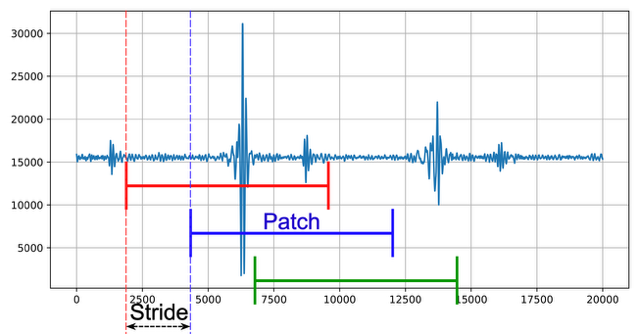

In [6]:
from IPython.display import Image, display

# Visualization of three patches
image_path = '/content/drive/MyDrive/circor-dataset/heartbeat_v1.png'
display(Image(filename=image_path))

In [ ]:
# TODO: Provide this class already implemented
class PCGDataPreparer:
    def __init__(self, patch_size: int , stride: int, number_channels: int=2, num_states: int=4):
        self.patch_size = patch_size
        self.stride = stride
        self.number_channels = number_channels
        self.num_states = num_states
        self.features = None
        self.labels = None

    def _compute_pcg_patches(self, sound, label):
        num_samples = len(sound)
        num_windows = int((num_samples - self.patch_size) / self.stride) + 1
        for window_idx in range(num_windows):
            patch_start = window_idx * self.stride
            yield sound[patch_start:patch_start + self.patch_size, :],  label[patch_start: patch_start + self.patch_size, :]

        window_remain = num_samples - self.patch_size
        if window_remain % self.stride > 0:
          yield sound[window_remain:, :], label[window_remain:, :]

    def set_features_and_labels(self, features, labels):
        self.features = features
        self.labels = labels
        num_observations = len(self.features)
        total_windows = 0
        for obs in features:
          num_samples = len(features)
          num_windows = int((num_samples - self.patch_size) / self.stride) + 1
          window_remain = num_samples - self.patch_size
          if window_remain % self.stride > 0:
              num_windows += 1
          total_windows += num_windows
        self.num_steps = total_windows

    def __call__(self):
        num_observations = len(self.labels)
        for obs_idx in range(num_observations):
            features = tf.stack(self.features[obs_idx], axis=1) # np.column_stack
            labels = self.labels[obs_idx]
            for s,y in (self._compute_pcg_patches(features, labels)):
              yield s, y

## 2.1.1 Instantiating the Data Preparers

We will now create an instance of the class `PCGDataPreparer` for each dataset.

---



In [ ]:
patch_size = 64
nch = 2 # Change this if you have more than 2 features
stride = 32
train_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
train_dp.set_features_and_labels(train[:, [3,4]], train[:, 5])

val_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
val_dp.set_features_and_labels(val[:, [3,4]], val[:, 5])

test_dp = PCGDataPreparer(patch_size=patch_size,
                     number_channels=nch,
                     stride=stride,
                     num_states=4)
test_dp.set_features_and_labels(test[:, [3,4]], test[:, 5])

## 2.1.2 TensorFlow Dataset and caching
Run the following code to create the Tensorflow Dataset objects using our custom data generator. We will be using `.cache()` and `.prefetch()` from the [tf.Data API](https://www.tensorflow.org/guide/data_performance) to minimize the overhead of computing each batch of data online.

In [ ]:
BATCH_SIZE = 32

def get_data_from_generator(*, data_processor, batch_size, patch_size, number_channels, number_classes, trainable=True):
    data = tf.data.Dataset.from_generator(data_processor,
                                          output_signature=(
                                              tf.TensorSpec(shape=(patch_size, number_channels), dtype=tf.float32),
                                              tf.TensorSpec(shape=(patch_size, number_classes), dtype=tf.float32))
                                          )
    if trainable:
        data.cache()
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

train_dataset = get_data_from_generator(data_processor=train_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=True)


val_dataset = get_data_from_generator(data_processor=val_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=False)

test_dataset = get_data_from_generator(data_processor=test_dp,
                                                batch_size=BATCH_SIZE,
                                                patch_size=patch_size,
                                                number_channels=nch,
                                                number_classes=4,
                                                trainable=False)

# 3. Training pipeline - The U-Net Architecture
Introduced by [Ronneberg et al.](https://arxiv.org/abs/1505.04597) in 2015, the U-Net is ubiquitous in biomedical signal and image processing tasks.

Although its efficacy is a result of several advancements of modern deep learning and optimization techniques, one of its characteristic architetural patterns are the skip connections from the encoder to the decoder.

The idea is that low-resolution information is important for medical domains, which can be complementary to the semantical rich features in the decoder.

Inspect and run the code below of a template for a simple U-Net adapted to process signals instead of images; using 1D instead of 2D primitives.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, concatenate

def example_unet(patch_size, nch, dropout=0.0):
    inputs = tf.keras.layers.Input(shape=(patch_size, nch))
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    pool1 = tf.keras.layers.Dropout(dropout)(pool1)

    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv2)

    up_prep = tf.keras.layers.UpSampling1D(size=2)(conv2)

    up = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(8, 2, padding='same')(up_prep), conv1], axis=2)
    up = tf.keras.layers.Dropout(dropout)(up)
    convout = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(up)
    convout = tf.keras.layers.Conv1D(8, 3, activation='tanh', padding='same')(convout)

    output_layer = tf.keras.layers.Conv1D(4, 1, activation='softmax')(convout)

    model = tf.keras.Model(inputs=[inputs], outputs=[output_layer])
    return model


In [ ]:
model = example_unet(64, 2)
print(model.summary())

## 3.1 - Design your U-Net
Can you improve the design of the U-Net, for instance, by adding more layers to increase its discriminative power?

In [ ]:
def your_unet(patch_size, nch, ...):
    # Your code
    model = ...
    return model

## 3.1 Hyperparameter setting
Instantiate your U-Net model and select a set of adequate metrics to track.

Early stopping on validation set is performed using `ModelCheckpoint` on `val_loss`.



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCHS = # your epochs
learning_rate =  # your lr
model = your_unet(patch_size, nch)  # use your unet_here
checkpoint_path = 'unet_weights/unet.keras'
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', 'precision', 'recall'])
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True)
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    verbose=1,
                    shuffle=True, callbacks=[model_checkpoint])

model.load_weights(checkpoint_path)

## 3.2 Hyperparameter tuning
Can you choose better hyperparameters an
d/or optimizer settings? Observe it improves your training metrics.

If you want to experiment with different batch sizes you have to run cells 2.1.2 again. If you also want to change stride, you will have to start from 2.1.1.



# 4. Inference pipeline
Collect the predictions of the U-Net

In [ ]:
predictions_train = model.predict(train_dataset)
val_test = model.predict(val_dataset)
predictions_test = model.predict(test_dataset)

## 4.1. Post-processing
`predictions_test` has the predictions on the test-set patch-wise in a patient agnostic fashion.

We now need to associate the appropriate outputs for each recording in an adequate fashion. Moreover, the fact that we used an overalpping slidding window means that we will have several heart state estimates for a given time $t$.

We will be averaging the U-Net's predictions across the patch dimension. Use the same strategy you used in the `PCGDataPreparer`. Let $N_{P_i} = \lceil  \frac{T_i - P}{\tau} \rceil$

$$\tilde{\mathbf{y}}_i(t, \tau) = \frac{1}{N_{P_i}}\sum_{t=1}^{N_{P_i}} \text{U-Net}(\mathbf{x}_i(t, \tau)| \theta^*)$$
So $\tilde{\mathbf{y}}_i$ should have shape $(T_i, 4)$.

Inspect the function `process_unet_predictions`. It should return the predicted label sequence (in ordinal form, not one-hot-encoded), and the corresponding probabilty estimates. **It follows a similar logic to 2.1 of this tutorial** .

In [ ]:
def process_unet_predictions(preds, dataframe, dataset, patch_size, stride):
  num_observations = len(dataframe)
  output_probs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  output_seqs = np.ndarray(shape=(num_observations), dtype=np.ndarray)
  preds_idx = 0
  for idx, sample in tqdm(enumerate(dataframe)):
    sound = sample[2]
    sound_duration = len(sound)
    # number of patches associated to this sound
    number_patches = int((sound_duration - patch_size) / stride)
    if (sound_duration - patch_size) % stride > 0:
      number_patches += 1
    prob_sound = np.zeros((number_patches, sound_duration, 4))
    for i in range(number_patches):
      prob_sound[i, i * stride:i * stride + patch_size, :] = preds[preds_idx, :, :]
      preds_idx += 1
    if (sound_duration - patch_size) % stride > 0:
      prob_sound[number_patches - 1, sound_duration - patch_size:, :] = preds[preds_idx, :, :]
      preds_idx +=1

    probs_patch = tf.reduce_sum(prob_sound, axis=0)
    probs_patch_normalized = probs_patch /  (tf.reduce_sum(prob_sound, axis=[0,2])[:, tf.newaxis] + 1e-12)
    output_probs[idx] = probs_patch_normalized
    output_seqs[idx] = tf.argmax(probs_patch_normalized, axis=1)
  return output_probs, output_seqs


probs, predictions = process_unet_predictions(predictions_test, test, test_dataset, patch_size, stride)


## 4.2 Decoding

The U-Net outputs estimates patch-by-patch, meaning it can output invalid heart sequences, e.g. going from S1 directly to S2 (we are assuming that screening is not interrupted here).

Implement a deconding function that takes the sequence predicted patch-by-patch that you recovered using `process_unet_predictions` and processes the output to be valid. You can change the output according to any criteria you want.

The function you implement should pass the unit test in the cell bellow.

In [ ]:
def your_deconding_function(seq, num_states=4):
  return seq

test_seq = np.array([1, 1, 1, 2, 1, 2, 2, 3, 3, 0, 3])
exp_seq = np.array([1, 1, 1, 2, 2, 2, 2, 3, 3, 0, 0])

your_deconding_function(test_seq)
assert np.all(exp_seq == test_seq)

## 4.3. Get the ground truth and predicted state sequences
Run the code below to get the state sequences.

In [ ]:
ground_truth = np.array([np.argmax(y, axis=1) for y in tqdm(test[:, -2])], dtype=object)
predictions = np.array([your_deconding_function(prediction.numpy()) for prediction in predictions], dtype=object)

## 5. Evaluation - metrics of Schmidt et al.

We will follow [Schmidt et al.](https://iopscience.iop.org/article/10.1088/0967-3334/31/4/004/pdf). A sound is true positive (TP) or correctly located if
the middle of the detected sound is closer than 60 ms to the middle of a similarly predefined sound, all other detected sounds were defined as false positive (FP).

Sensitivity is defined as:
\begin{equation}
\text{Sensitivity} = \frac{\text{number of TP sounds}}{\text{total number of S1 and S2 sounds}}
\end{equation}

and positive predictivity ($P_+$):
\begin{equation}
P_+ = \frac{\text{number of TP sounds}}{\text{number of TP sounds} + \text{number of FP sounds}}.
\end{equation}

These metrics are tricky to implement so we provide them beforehand (the authors may or may not had a little help of o1-preview for this step:))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
def extract_state_runs(labels, desired_states):
    """
    Extract continuous runs of the desired states from labels.

    Args:
        labels: numpy array of labels.
        desired_states: set of desired state values.

    Returns:
        A list of dictionaries with keys:
            'start': start index of the run
            'end': end index of the run (inclusive)
            'midpoint': midpoint index of the run
            'state': the state value (0 or 2)
    """
    # Ensure labels is a 1D array
    labels = np.asarray(labels).flatten()

    runs = []
    N = len(labels)
    in_run = False
    run_start = 0
    run_state = None

    for i in range(N):
        label_i = labels[i]
        # If label_i is an array (e.g., from a structured array), extract scalar
        if isinstance(label_i, np.ndarray):
            label_i = label_i.item()
        if label_i in desired_states:
            if not in_run:
                # Start of a new run
                in_run = True
                run_start = i
                run_state = label_i
        else:
            if in_run:
                # End of the run
                run_end = i - 1
                midpoint = (run_start + run_end) // 2
                runs.append({
                    'start': run_start,
                    'end': run_end,
                    'midpoint': midpoint,
                    'state': run_state
                })
                in_run = False
                run_state = None
    # Check if we're still in a run at the end
    if in_run:
        run_end = N - 1
        midpoint = (run_start + run_end) // 2
        runs.append({
            'start': run_start,
            'end': run_end,
            'midpoint': midpoint,
            'state': run_state
        })
    return runs

def compute_ppv_sensitivity(ground_truth, predictions, sample_rate, threshold=60e-3):
    """
    Compute PPV and sensitivity for states 0 and 2.

    Args:
        ground_truth: numpy array of ground truth labels.
        predictions: numpy array of predicted labels.
        sample_rate: sampling rate in Hz.

    Returns:
        ppv: Positive Predictive Value.
        sensitivity: Sensitivity (Recall).
    """
    # Ensure ground_truth and predictions are 1D arrays
    ground_truth = np.asarray(ground_truth).flatten()
    predictions = np.asarray(predictions).flatten()

    # Desired states
    desired_states = {0, 2}

    # Maximum distance in samples (treshold in seconds vs fs)
    max_distance_samples = int(threshold * sample_rate)

    # Extract runs from ground truth and predictions
    gt_runs = extract_state_runs(ground_truth, desired_states)
    pred_runs = extract_state_runs(predictions, desired_states)

    # Get midpoints and states
    gt_midpoints = np.array([run['midpoint'] for run in gt_runs])
    gt_states = np.array([run['state'] for run in gt_runs])

    pred_midpoints = np.array([run['midpoint'] for run in pred_runs])
    pred_states = np.array([run['state'] for run in pred_runs])

    # Initialize matches
    matched_gt_indices = set()
    matched_pred_indices = set()

    # Build potential matches
    potential_matches = []
    for i, (p_mid, p_state) in enumerate(zip(pred_midpoints, pred_states)):
        for j, (gt_mid, gt_state) in enumerate(zip(gt_midpoints, gt_states)):
            if gt_state == p_state:
                distance = abs(p_mid - gt_mid)
                if distance <= max_distance_samples:
                    potential_matches.append((i, j, distance))

    # Sort potential matches by distance
    potential_matches.sort(key=lambda x: x[2])

    # Perform matching
    TP = 0
    for i, j, d in potential_matches:
        if i not in matched_pred_indices and j not in matched_gt_indices:
            matched_pred_indices.add(i)
            matched_gt_indices.add(j)
            TP += 1

    # Compute FP and FN
    total_pred = len(pred_midpoints)
    total_gt = len(gt_midpoints)
    FP = total_pred - len(matched_pred_indices)
    FN = total_gt - len(matched_gt_indices)

    # Compute PPV and Sensitivity
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    return ppv, sensitivity


def compute_schmidt_metrics(ground_truth, sequences, sampling_rate):
  ppvs, sensitivities, accuracies = [], [], []
  for i in tqdm(range(len(ground_truth))):
    ppv, sensitivity = compute_ppv_sensitivity(ground_truth[i],
                                               sequences[i],
                                               sampling_rate)
    ppvs.append(ppv)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy_score(ground_truth[i], sequences[i]))
  return np.array(ppvs), np.array(sensitivities), np.array(accuracies)


ppv, sens, acc = compute_schmidt_metrics(ground_truth, predictions, sampling_rate=50)

# 5.1 Inspect results
Inspect a result where your metrics had satisfactory performance (all above 90\%) and one where the result was less positive. Discuss the differences.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(ground_truth, seqs, idx):

  # Define the window width in terms of seconds and convert to the corresponding sample range
  window_duration = 0.1  # 0.06 ms in seconds
  sample_interval = 1 / 50  # Time per sample in seconds (20 ms per sample at 50 Hz)

  # Calculate the equivalent width in terms of sample indices (will be <1)
  window_width_samples = window_duration / sample_interval

  # Create the plot
  plt.figure(figsize=(24, 6))

  # Plot ground truth and predictions with discrete markers and dotted lines
  plt.plot(ground_truth[idx], 'o--', label='Ground Truth', markersize=6)
  plt.plot(seqs[idx], 'o--', color='red', label='Predictions', markersize=6)


  # Set labels and legend
  plt.title(f'Signal at idx {idx} with 0.06 ms reference window')
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()



See if you can find an example where the segmentation is plausible with good metrics, and the other that is not.

Use `visualize_predictions` to do so.

In [ ]:
idx = 0
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

In [ ]:
idx = 100
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

# 5.2 - Bonus points

What other architectural changes do you think would be suitable for this problem?

Can you think of possible data augmentation schemes for this problem?


# 6. Classification
Let us solve the classification task of Murmur detection. First, let us visualize the distribution of class. Remember that the ordinal classes represent the following:

0 - normal; 1- murmur; 2-unknown.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example one-hot encoded labels (each row corresponds to one label)

def plot_label_frequency(ordinal_labels, ax, title):
    ax.hist(ordinal_labels, bins=np.arange(ordinal_labels.max() + 2) - 0.5, edgecolor='black')
    ax.set_xticks(np.arange(ordinal_labels.max() + 1))
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
# Plot the histogram
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the histograms for train, val, and test
plot_label_frequency(train[:, -1], axes[0], 'Train Label Occurrences')
plot_label_frequency(val[:, -1], axes[1], 'Val Label Occurrences')
plot_label_frequency(test[:, -1], axes[2], 'Test Label Occurrences')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## 6.1 - Fixing the dimensions of the classifier

One of the challenges of this dataset is that the inputs are sequential and of variable length. While it should not make a difference from a theoretical standpoint, the deep neural network APIs such as TensorFlow or PyTorch are optimized to work with fixed length inputs.

In the first part we did not had to worry with this explicitely, because we trained the U-Net patch by patch, and only processed each recording sequences post-hoc. However, now our model will have to receive entire sounds during training, since the labels depend on the entire recording.

We will provide you the most basic solution for this: we will get rid of the temporal dimension $T_i$ by pooling.

## 6.1.1. - Naive classifier - The characteristic U-Net representation

Our goal is to learn a fixed-length representation $E \in \mathbb{R}^d$ so that we can then feed it to a downstream classifier learning the mapping $\mathbb{R}^d → \{0, 1, 2\}$. Again we will be using a deep neural network, and we are going to take advantage of the logits of the U-Net, i.e., the output of the softmax that provides us with a *continuous representation of the signal*.

Specifically, we are going to collect the logits after sequence decoding. Our hope is that the "confidence" of the U-Net will correlate with the presence/absence of murmurs. Moreover, if the pathology affects the dynamics of the heart-cycle in terms of the duration of each state, then these representations should naturally embed that information provided that the U-Net is a computetend fundamental heart sound segmentator.

Remember from **Section 2.1.2 of Tutorial 1** that the standard deviation of the noise of the sound is mitigated by a factor of $\frac{1}{\sqrt{T_i}}$. A possible strategy of characterizing the PCG of a patient is precisely by its characteristic heart cycle.

Our naive classifier will take as input the normalized average "energy" of each heart sound in recording $i$ according to the U-Net. Specifically:

$$\mathbf{x}_i^\text{characteristic}(\theta^*) = \frac{1}{T_i}\sum_{i=1}^{T_i} \text{U-Net}(x_i| \theta^*)$$

We will use a multi-layer perceptron (MLP) to map $\mathbf{x}_i^\text{characteristic}$ to its associated class.

Collect the processed logits using `process_unet_predictions` for the `train`, `val`, and `test` datasets and compute the characteristic heart sound according to the above formulation.

In [ ]:
probs_train, predictions_train = process_unet_predictions(predictions_train, train, train_dataset, patch_size, stride)
probs_val, predictions_val = process_unet_predictions(val_test, val, val_dataset, patch_size, stride)
probs_test, predictions_test = process_unet_predictions(predictions_test, test, test_dataset, patch_size, stride)

In [ ]:
probs_train_ = np.array([np.sum(prob, axis=0) / prob.shape[0] for prob in probs_train], dtype=object)
probs_val_ = np.array([np.sum(prob, axis=0) / prob.shape[0] for prob in probs_val], dtype=object)
probs_test_ = np.array([np.sum(prob, axis=0) / prob.shape[0] for prob in probs_test], dtype=object)

In [ ]:
probs_train[0].shape, probs_train_[0].shape

## 6.2.1 - Classification inference pipeline
Like in section 2.1.2 of this tutorial, we need to create a `tf.data.Dataset` object in order to train our custom models.

We provide the code for the `PCGDataPreparerClassifier` which is designed for our naive classifier.

In [ ]:
BATCH_SIZE = 32

class PCGDataPreparerClassifier:
    def __init__(self, features, labels, num_states: int=3):
        self.x = features
        self.y = labels
        self.num_states = num_states

    def __call__(self):
        num_observations = len(self.x)
        for idx in range(num_observations):
          yield self.x[idx], tf.one_hot(self.y[idx], depth=self.num_states)

dp_train = PCGDataPreparerClassifier(probs_train_, train[:, -1], num_states=3)
dp_val = PCGDataPreparerClassifier(probs_val_, val[:, -1], num_states=3)
dp_test = PCGDataPreparerClassifier(probs_test_, test[:, -1], num_states=3)
def get_data_from_generator_classifier(*, data_processor, batch_size, number_channels, number_classes, trainable=True):
    data = tf.data.Dataset.from_generator(data_processor,
                                          output_signature=(
                                              tf.TensorSpec(shape=(number_channels), dtype=tf.float32),
                                              tf.TensorSpec(shape=(number_classes), dtype=tf.float32))
                                          )
    if trainable:
        data = data.shuffle(5000, reshuffle_each_iteration=True)
        data.cache()
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

train_dataset = get_data_from_generator_classifier(data_processor=dp_train,
                                                batch_size=BATCH_SIZE,
                                                   number_channels=4,
                                                number_classes=3,
                                                trainable=True)


val_dataset = get_data_from_generator_classifier(data_processor=dp_val,
                                                batch_size=BATCH_SIZE,
                                                 number_channels=4,
                                                number_classes=3,
                                                trainable=False)


test_dataset = get_data_from_generator_classifier(data_processor=dp_test,
                                                batch_size=BATCH_SIZE,
                                                  number_channels=4,
                                                number_classes=3,
                                                trainable=False)


## 6.2.2 - The MLP architecture

We will design a simple two layer MLP, comprised of a batch normalization layer and an output layer with a `softmax` function.

In [ ]:
# Create the MLP model
model = tf.keras.Sequential()
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6.2.3 - Classifier training pipeline
Complete the following code to
* Train for 50 epochs
* Perform early stopping according to the minimum validation loss
* Start with a learning rate of `1e-3`
* Select your favorite stochastic gradient descent optimizer
* Select at least `accuracy`, `precision`, and `recall` as your metrics


In [ ]:
from sklearn.utils import class_weight
checkpoint_path = 'classifier/checkpoint.keras'
EPOCHS = 50

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', 'precision', 'recall', 'auc'])
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_checkpoint])

model.load_weights(checkpoint_path)

model.evaluate(test_dataset)

## 6.2.4 - Evaluation
Evaluate the model on the test set. Give aggregated and per class accuracy, precision, and recalls.

In [ ]:
preds_test = model.predict(test_dataset)
preds_test = np.argmax(preds_test, axis=-1)

In [ ]:
labels_test = test[:, -1].astype(np.int32)
preds_test = preds_test.astype(np.int32)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
accuracy = accuracy_score(labels_test, preds_test)
print(f'Overall Accuracy: {accuracy:.4f}')
report = classification_report(labels_test, preds_test)
print(report)

## 6.2.5 - Bonus: Improve classifier
The distribution is clearly unbalanced. Do you think this is problematic given the performance you observe on the test set?

Can you improve the training routine to account for this unbalance without changing the architecture?

## 6.2.6 - Bonus: Improve pipeline
Murmurs may only be present in the systole or the diastole. However, our previous representation uses all of the fundamental heart sounds to output a prediction. Can you leverage this prior information to improve performance? Could you use the U-Net predictions to extract the location of the sounds in the original spectogram?

After this; do you think you can improve the classifier as a whole? What if we had another type of fixed representation; say the MFCC or PSD of the recordings with a fix dimension, could we use a more sophisticated architecture? Try to implement it. If you do not have time, write down your thoughts in a text cell!

# Final submission
Send your .ipynb files to francesco.renna@fc.up.pt as well as 3 slides summarizing your approaches for both tutorials 1 and 2.